In [1]:
import re, os
import unicodedata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import nltk.sentiment

from wordcloud import WordCloud

from acquire_c import *
from prepare_c import *
from explore_c import *

plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

### Acquire the Data

In [2]:
# You can pass a threshold argument but the default is 75
df = get_readme_data()
df.head()

,readme,prog_lang,original,stemmed,lemmatized
0,wip,JavaScript,🚧 WIP,wip,wip
1,abhisheknaiidu cli table contents installation...,JavaScript,abhisheknaiidu The CLI Table of Contents Ins...,abhisheknaiidu cli tabl content instal built l...,abhisheknaiidu cli table content installation ...
2,interview preparation arrays sieve catalan num...,C++,Interview Preparation Arrays Sieve Catalan N...,interview prepar array siev catalan number sli...,interview preparation array sieve catalan numb...
3,hacktoberfest 2020 hacktoberfest encourages pa...,JavaScript,Hacktoberfest 2020 🎉 🗣 Hacktoberfest encour...,hacktoberfest 2020 hacktoberfest encourag part...,hacktoberfest 2020 hacktoberfest encourages pa...
4,apop apop hd music stream sharing application ...,JavaScript,A-POP 🎶 A-POP is a HD Music Stream and Shar...,apop apop hd music stream share applic built o...,apop apop hd music stream sharing application ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13792 entries, 0 to 13791
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   readme      13777 non-null  object
 1   prog_lang   13792 non-null  object
 2   original    13792 non-null  object
 3   stemmed     13777 non-null  object
 4   lemmatized  13777 non-null  object
dtypes: object(5)
memory usage: 646.5+ KB


There are a few null values for the README content. Since there are so many entries, I'll just drop those rows for now.

In [4]:
df = df.dropna()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13777 entries, 0 to 13791
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   readme      13777 non-null  object
 1   prog_lang   13777 non-null  object
 2   original    13777 non-null  object
 3   stemmed     13777 non-null  object
 4   lemmatized  13777 non-null  object
dtypes: object(5)
memory usage: 645.8+ KB


__What are the most popular programming languages?__

Next, I will determine what the top 4 most common languages are. Since there are so many others languages available, I will group the others into a bin called 'others'.

I will also group the languages 'Jupyter Notebook' and 'Python' together, since code written in jupyter notebooks is most commonly Python. 

In [6]:
df.prog_lang.value_counts(normalize = False).head()

JavaScript          3120
Python              2802
Jupyter Notebook    1642
Java                1174
HTML                 941
Name: prog_lang, dtype: int64

After looking at the numbers above, I will set the target labels to be 'Javascript', 'Python', 'Java', 'HTML', and 'Other'.

Now I will go ahead and group as stated earlier.

In [7]:
#Create a function that changes the programming language label as necessary
def change_lang(string):
    """
    This function will take in a programming language name as a string, 
    and change it as so:
    
    JavaScript -> JavaScript
    Python -> Python
    Jupyter Notebook -> Python
    Java -> Java
    HTML -> HTML
    Anything Else -> Other
    """
    
    if string == 'JavaScript':
        return string
    elif string == 'Jupyter Notebook' or string == 'Python':
        return 'Python'
    elif string == 'Java':
        return string
    elif string == 'HTML':
        return string
    else:
        return 'Other'


In [8]:
#Apply the change_lang function to the df
df.prog_lang = df.prog_lang.apply(change_lang)

In [9]:
df.prog_lang.value_counts()

Python        4444
Other         4098
JavaScript    3120
Java          1174
HTML           941
Name: prog_lang, dtype: int64

In [41]:
#Create a function to get the character count of each doc
def get_char_count(string):
    """
    This function will take in a string and return the number of characters in it.
    """
    
    return len(string)

In [46]:
#apply the above function to get the character counts of the lemmatized docs
df['lem_char_count'] = df.lemmatized.apply(get_char_count)

In [48]:
#Now create a function to get the word count of the lemmatized docs
def get_word_count(string):
    """
    This function will take in a string and return the number of words in that string.
    This function will include repeat words.
    """
    
    #Create a list of words separated by a space
    words = string.split()
    
    return len(words)

In [49]:
#apply the above function to get the word counts of the lemmatized docs
df['lem_word_count'] = df.lemmatized.apply(get_word_count)

In [51]:
#Create a function that gets the unique word count
def get_unique_words(string):
    """
    This function will take in a string and return the number of unique words in that string.
    """
    
    words = string.split()
    words = set(words)
    
    return len(words)

In [52]:
#Apply the above function to get the unique word counts of the lemmatized docs
df['lem_unique_word_count'] = df.lemmatized.apply(get_unique_words)

In [54]:
#Create a function to get the number of sentences in a string
def get_sentence_count(string):
    """
    This function will take in a string and return the number of sentences in that string.
    """
    
    sentences = nltk.sent_tokenize(string)
    
    return len(sentences)

In [56]:
#For first time use
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/johnathonsmith/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [57]:
#Apply the above function to get the unique word counts of the lemmatized docs
df['sentence_count'] = df.original.apply(get_sentence_count)

In [63]:
#Get the average number of words per sentence
df['avg_words_per_sentence'] = round(df.lem_word_count / df.sentence_count).astype(int)

In [66]:
#For first use
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/johnathonsmith/nltk_data...


True

In [69]:
#Now create a function to get the sentiment analysis of each original doc
def get_sentiment_compound(string):
    """
    This function will take in a string analyze the sentiment, and return the compound
    value.
    """
    
    sia = nltk.sentiment.SentimentIntensityAnalyzer()
    
    #sia returns a dict, so access the compound score accordingly
    compound = sia.polarity_scores(string)['compound']
    
    return compound

In [71]:
#apply the above function to the original docs
df['sentiment'] = df.original.apply(get_sentiment_compound)

In [76]:
#Create a function to get the stopword counts from the original doc
def get_stopword_count(string):
    """
    This function takes in a string and returns the number of stopwords in that string.
    """
    
    #Create a list of the words in the string
    words = string.split()
    
    #Initialize the count var
    count = 0
    
    #Loop through each word and check whether or not it is in the stopword dict
    #If it is, increase count by 1
    
    for word in words:
        if word in stopwords.words('english'):
            count += 1
    
    return count

In [77]:
df['stopword_count'] = df.original.apply(get_stopword_count)

In [81]:
#Create a column for the stopword to word ratio
df['word_stopword_ratio'] = round(df.stopword_count / df.lem_word_count, 2)

In [82]:
df

,readme,prog_lang,original,stemmed,lemmatized,char_count,lem_char_count,lem_word_count,lem_unique_word_count,sentence_count,avg_words_per_sentence,sentiment,stopword_count,word_stopword_ratio
0,wip,JavaScript,🚧 WIP,wip,wip,6,3,1,1,1,1,0.0000,0,0.00
1,abhisheknaiidu cli table contents installation...,JavaScript,abhisheknaiidu The CLI Table of Contents Ins...,abhisheknaiidu cli tabl content instal built l...,abhisheknaiidu cli table content installation ...,653,501,67,59,5,13,0.8658,20,0.30
2,interview preparation arrays sieve catalan num...,Other,Interview Preparation Arrays Sieve Catalan N...,interview prepar array siev catalan number sli...,interview preparation array sieve catalan numb...,7078,5876,872,339,11,79,0.9891,147,0.17
3,hacktoberfest 2020 hacktoberfest encourages pa...,JavaScript,Hacktoberfest 2020 🎉 🗣 Hacktoberfest encour...,hacktoberfest 2020 hacktoberfest encourag part...,hacktoberfest 2020 hacktoberfest encourages pa...,702,546,68,60,6,11,0.7088,24,0.35
4,apop apop hd music stream sharing application ...,JavaScript,A-POP 🎶 A-POP is a HD Music Stream and Shar...,apop apop hd music stream share applic built o...,apop apop hd music stream sharing application ...,1340,1053,139,98,6,23,0.9421,47,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13787,stockhawk,Java,Stock-Hawk,stockhawk,stockhawk,10,9,1,1,1,1,0.0000,0,0.00
13788,vscodenbpreviewer extension supercharging data...,JavaScript,vscode-nbpreviewer An extension for supercharg...,vscodenbpreview extens supercharg data scienc ...,vscodenbpreviewer extension supercharging data...,316,268,35,27,3,12,0.0000,9,0.26
13789,solution avito demand competition peter hurfor...,Python,Solution to the Avito Demand Competition by Pe...,solut avito demand competit peter hurford lear...,solution avito demand competition peter hurfor...,652,478,72,57,11,7,0.2263,27,0.38
13790,terminalleetcode terminalleetcode terminal bas...,Python,Terminal-Leetcode Terminal-Leetcode is a termi...,terminalleetcod terminalleetcod termin base le...,terminalleetcode terminalleetcode terminal bas...,3258,2345,379,169,41,9,0.9833,176,0.46


Now that the languages have been grouped appropriately, I will split the df into train, validate, and test sets. After that, I will begin exploring only on the train data set.d

__Splitting the Data__

In [10]:
from sklearn.model_selection import train_test_split

#The following function will be used in the prep functions to return the train, validate, and test splits
def train_validate_test_split(df, target, seed = 123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [83]:
#Split the data and stratify across programming language
train, validate, test = train_validate_test_split(df, 'prog_lang')
train.shape, validate.shape, test.shape

((7714, 14), (3307, 14), (2756, 14))

### Explore the Data

Now I will begin exploring on only the train data set.

I will first separate each language into its own group for easier exploration.

In [84]:
#Before we begin, what are the train value counts?
train.prog_lang.value_counts()

Python        2488
Other         2295
JavaScript    1747
Java           657
HTML           527
Name: prog_lang, dtype: int64

In [85]:
#Split into language groups
python = train[train.prog_lang == 'Python']
js = train[train.prog_lang == 'JavaScript']
java = train[train.prog_lang == 'Java']
html = train[train.prog_lang == 'HTML']
other = train[train.prog_lang == 'Other']

Now, I will get the frequencies of all the words in each category, add them to a df, and begin comparing them.

In [86]:
#First, I need to combine all the lemmatized text from each category
python_words = ' '.join(python.lemmatized)
js_words = ' '.join(js.lemmatized)
java_words = ' '.join(java.lemmatized)
html_words = ' '.join(html.lemmatized)
other_words = ' '.join(html.lemmatized)
#I will also do this for the train set as a whole
all_words = ' '.join(train.lemmatized)

In [87]:
#Now, I will save the word frequencies of each group as a series
python_freq = pd.Series(python_words.split()).value_counts()
js_freq = pd.Series(js_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
other_freq = pd.Series(other_words.split()).value_counts()
#Again, do this for the train set as a whole
all_freq = pd.Series(all_words.split()).value_counts()

In [88]:
#Now concatenate each series into a single df
word_counts = pd.concat([python_freq, js_freq, java_freq, html_freq, other_freq, all_freq], axis = 1).fillna(0).astype(int)
word_counts.columns = ['Python', 'JavaScript', 'Java', 'HTML', 'Other', 'All']
word_counts.head()

,Python,JavaScript,Java,HTML,Other,All
yes,16001,162,25,5,5,16326
unknown,10402,37,1,2,2,10459
data,9647,2011,580,622,622,14670
python,7887,151,623,332,332,9387
apikey,5552,17,0,0,0,5571


Now I will create a visualization of the top 20 most common words and compare across languages.

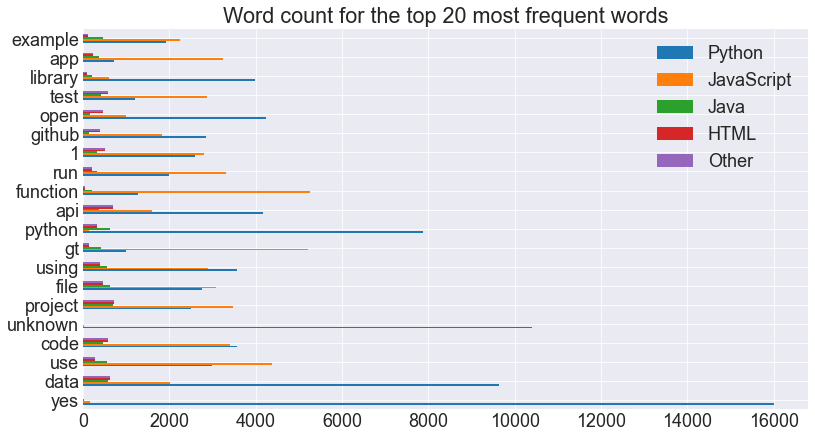

In [89]:
plt.rc('font', size=18)
word_counts.sort_values('All', ascending=False).head(20)[['Python', 'JavaScript', 'Java', 'HTML', 'Other']].plot.barh()
plt.title('Word count for the top 20 most frequent words')
plt.show()

__Key Takeaways:__
    
* Although it's hard to see, you can tell that the words 'yes', 'unknown', 'python', 'api', 'library', and 'open' are mostly in python documents.
* The words 'gt', 'function', 'test', and 'app' are mostly in JavaScript docs.

In [93]:
#Compare average stopword ratios
train.groupby('prog_lang').word_stopword_ratio.mean()

prog_lang
HTML          0.262713
Java          0.256667
JavaScript    0.399954
Other         0.322362
Python        0.325096
Name: word_stopword_ratio, dtype: float64

Javascript and HTML both have smaller stopword ratios than the other languages.

In [94]:
#Compare median stopword ratios
train.groupby('prog_lang').word_stopword_ratio.median()

prog_lang
HTML          0.19
Java          0.22
JavaScript    0.42
Other         0.33
Python        0.33
Name: word_stopword_ratio, dtype: float64

Pretty much the same results, but its easier to see that the Javascript docs have far more stopwords than the other languages.

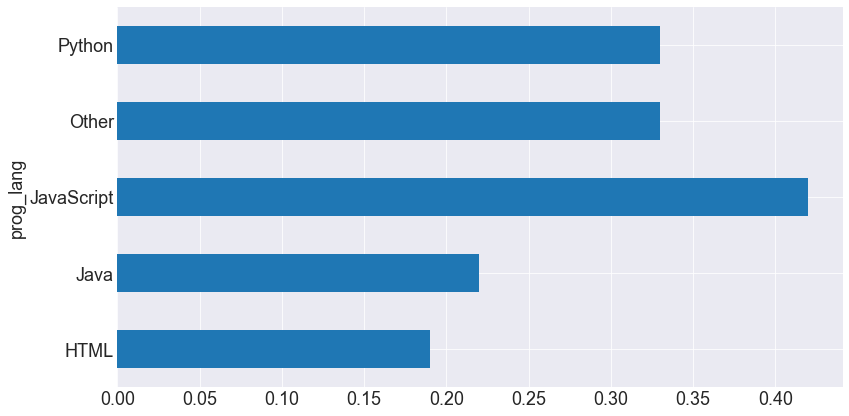

In [99]:
#Visualize the difference
train.groupby('prog_lang').word_stopword_ratio.median().plot.barh()
plt.show()

In [100]:
#Compare the average sentiment per language
train.groupby('prog_lang').sentiment.mean()

prog_lang
HTML          0.293673
Java          0.331147
JavaScript    0.570910
Other         0.457769
Python        0.421472
Name: sentiment, dtype: float64

Again, Java and HTML are very different from the others.

In [101]:
#Check the median sentiment
train.groupby('prog_lang').sentiment.median()

prog_lang
HTML          0.00000
Java          0.00000
JavaScript    0.85550
Other         0.51060
Python        0.45165
Name: sentiment, dtype: float64

Median sentiment for HTML and Java is 0, so that's an interesting find. Again, JavaScript stands out and has the highest median sentiment compound score.

<AxesSubplot:ylabel='prog_lang'>

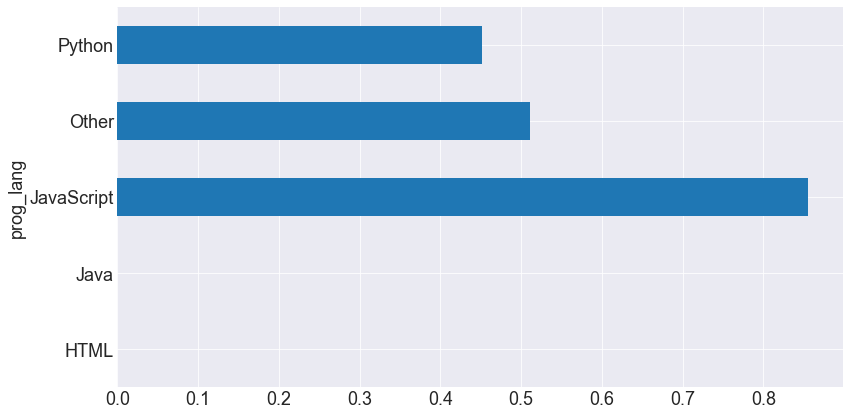

In [103]:
#Visualize the differences
train.groupby('prog_lang').sentiment.median().plot.barh()

In [105]:
#Now check out the unique word counts per language
train.groupby('prog_lang').lem_unique_word_count.mean()

prog_lang
HTML           78.036053
Java           95.322679
JavaScript    151.178592
Other         109.326362
Python        142.086415
Name: lem_unique_word_count, dtype: float64

In [106]:
train.groupby('prog_lang').lem_unique_word_count.median()

prog_lang
HTML          10.0
Java          20.0
JavaScript    82.0
Other         47.0
Python        47.5
Name: lem_unique_word_count, dtype: float64

So I'm noticing the same pattern over and over again. Java and HTML are usually the lowest in the group and JavaScript is usually the highest.

<AxesSubplot:ylabel='prog_lang'>

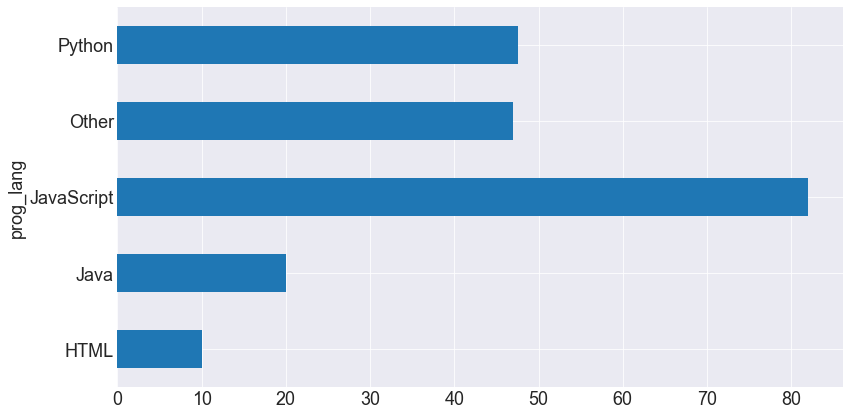

In [107]:
#Visualize the differences
train.groupby('prog_lang').lem_unique_word_count.median().plot.barh()

In [108]:
#Now compare average sentence lengths per language
train.groupby('prog_lang').avg_words_per_sentence.mean()

prog_lang
HTML          11.163188
Java          17.193303
JavaScript    16.392673
Other         18.267974
Python        20.103296
Name: avg_words_per_sentence, dtype: float64

In [109]:
train.groupby('prog_lang').avg_words_per_sentence.median()

prog_lang
HTML           7.0
Java           9.0
JavaScript    10.0
Other         11.0
Python        11.0
Name: avg_words_per_sentence, dtype: float64

So in this case, Other and Python have the most words per sentence. Might be useful in identifying them in modeling. Differences are huge though, so might not be super useful. 

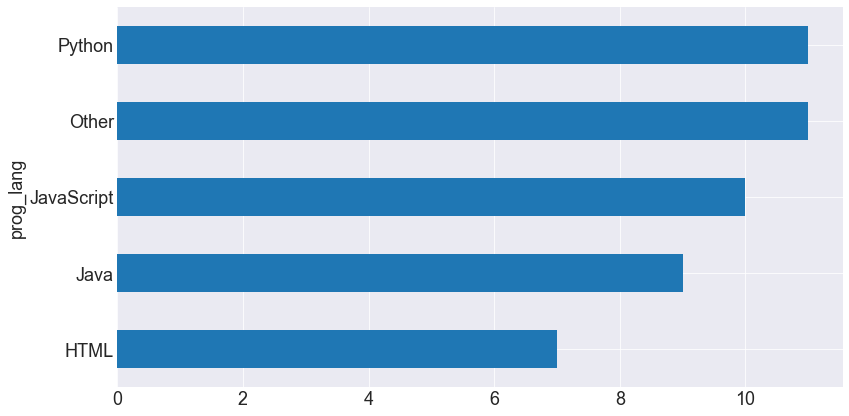

In [113]:
#Visualize the differences
train.groupby('prog_lang').avg_words_per_sentence.median().plot.barh()
plt.show()

In [114]:
#Compare the number of sentences per lang
train.groupby('prog_lang').sentence_count.mean()

prog_lang
HTML          16.018975
Java          13.881279
JavaScript    31.724671
Other         17.389107
Python        23.217042
Name: sentence_count, dtype: float64

In [115]:
train.groupby('prog_lang').sentence_count.median()

prog_lang
HTML          1.0
Java          2.0
JavaScript    9.0
Other         4.0
Python        4.0
Name: sentence_count, dtype: float64

It seems like there must be some pretty serious outliers to cause the mean and median to be so different. Based on the median, it looks like this is following the same pattern as before. Javascript has the highest, and Java and HTML have the lowest.

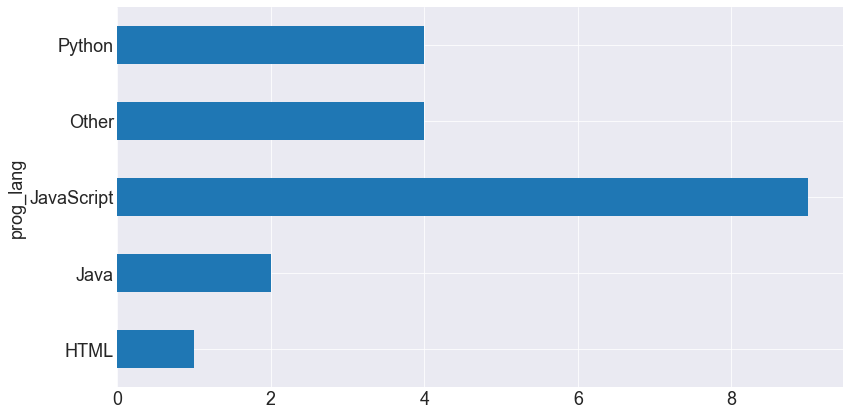

In [117]:
#Visualize the differences
train.groupby('prog_lang').sentence_count.median().plot.barh()
plt.show()

__Key Takeaways:__
    
* There seem to be some significant differences between the languages for the columns checked above, so I'd like to include most of them in modeling.
* That includes:
    - sentiment
    - stopword_ratio
    - unique_word_count
    - avg_words_per_sentence
    - sentence_count